In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Обучение дерева решений для решения задачи классификации

Построим дерево, решающее задачу определения, есть ли у ученика в табеле тройки, по трем бинарным признакам. 

In [2]:
students_data = [
    {
        'student': 'Вася',
        'attends_all_the_lessons': 1,
        'completes_all_the_homeworks': 0,
        'participates_in_contests': 0,
        'does_not_has_C_in_diploma': 1
    },
    {
        'student': 'Петя',
        'attends_all_the_lessons': 0,
        'completes_all_the_homeworks': 0,
        'participates_in_contests': 0,
        'does_not_has_C_in_diploma': 0
    },
    {
        'student': 'Кристина',
        'attends_all_the_lessons': 0,
        'completes_all_the_homeworks': 1,
        'participates_in_contests': 1,
        'does_not_has_C_in_diploma': 1
    },
    {
        'student': 'Полина',
        'attends_all_the_lessons': 0,
        'completes_all_the_homeworks': 1,
        'participates_in_contests': 0,
        'does_not_has_C_in_diploma': 0
    },
    {
        'student': 'Егор',
        'attends_all_the_lessons': 1,
        'completes_all_the_homeworks': 1,
        'participates_in_contests': 0,
        'does_not_has_C_in_diploma': 1
    },
    {
        'student': 'Света',
        'attends_all_the_lessons': 0,
        'completes_all_the_homeworks': 0,
        'participates_in_contests': 0,
        'does_not_has_C_in_diploma': 0
    }
]
students_pd = pd.DataFrame(students_data)
students_pd
students_pd.student.name

'student'

__GINI__
$$GINI = 1 - \sum_{i=1}^C p_i^2,$$
где $C$ - количество классов, $p_i$ - вероятность принадлежности $i-$тому классу (доля $i-$того класса в группе.  
Чем коэффициент меньше, тем лучше.

Примеры: у максимального разнообразного набора GINI будет большим, у однородного  - минимальным.

In [3]:
def calc_gini(values, classes = [0, 1]):
    if len(values) == 0:
        return 0
    
    res = 1
    for c in classes:
        res -= (len([v for v in values if v == c]) / len(values)) ** 2
    return res

In [4]:
bad_values = [1, 0, 1, 0, 1, 0]
calc_gini(bad_values)

0.5

In [5]:
super_bad_values = [1, 0, 2, 1, 0, 2, 1, 0, 2]
calc_gini(super_bad_values, classes=[0, 1, 2])

0.6666666666666665

In [6]:
good_values = [1, 1, 1, 1, 1, 1]
calc_gini(good_values)

0.0

Рассчитаем исходный джини

In [7]:
target_name = 'does_not_has_C_in_diploma'

In [8]:
init_gini = calc_gini(students_pd[target_name])
init_gini

0.5

Строим первый сплит

Расчитаем джини для разных наборов, получающихся при делении по фичам, и прирост информации.  
Прирост информации рассчитываем по формуле:
$$IG =gini_{before\ split} - gini_{left\ part} * ratio_{left\ part} - gini_{right\ part} * ratio_{right\ part} ,$$
где $gini$ - степень хаотичности в наборе, $ratio$ - доля элементов, попавших в новый лист после сплита

In [9]:
feature_names = ['attends_all_the_lessons', 'completes_all_the_homeworks', 'participates_in_contests']

In [10]:
def calc_options(dt, target_name, init_criterion_value, calc_criterion_value):
    max_information_gain = 0
    best_feature_split = None
    
    # перебираем все признаки
    for feature_name in feature_names:
        print(feature_name)
        
        # составляем значения для сплитов по признаку
        feature_values = dt[feature_name]
        diff_feature_values = sorted(set(feature_values)) #[0, 1]
        
        # перебираем возможные сплиты по признаку
        for i in range(len(diff_feature_values) - 1):
            
            information_gain = init_criterion_value
            
            # считаем значение сплита
            split_value = (diff_feature_values[i] + diff_feature_values[i+1]) / 2
            print(f'    Split value = {split_value}')
            
            # считаем хаотичность в левой группе
            values_in_group = dt.query(f'{feature_name} <= {split_value}')[target_name]
            criterion_value_for_group = calc_criterion_value(values_in_group)
            ratio_for_group = len(values_in_group) / len(dt[target_name])
            print(
                f'        For students with feature less than {split_value} target equals', 
                ' '.join(values_in_group.astype(str)),
                'criterion equals',
                criterion_value_for_group
            )
            information_gain -= criterion_value_for_group * ratio_for_group
            
            # считаем хаотичность в правой группе
            values_in_group = dt.query(f'{feature_name} > {split_value}')[target_name]
            criterion_value_for_group = calc_criterion_value(values_in_group)
            ratio_for_group = len(values_in_group) / len(dt[target_name])
            print(
                f'        For students with feature more than {split_value} target equals', 
                ' '.join(values_in_group.astype(str)),
                'criterion equals',
                criterion_value_for_group
            )
            information_gain -= criterion_value_for_group * ratio_for_group
            
            #считаем прирост иноформации
            if max_information_gain < information_gain:
                max_information_gain = information_gain
                best_feature_split = f'{feature_name}_{split_value}'
            print(f'        Information gain = {information_gain}')
        print()
    
    print(f'BEST feature_split: {best_feature_split} with information gain = {max_information_gain}')
        
calc_options(students_pd, target_name, init_gini, calc_gini)

attends_all_the_lessons
    Split value = 0.5
        For students with feature less than 0.5 target equals 0 1 0 0 criterion equals 0.375
        For students with feature more than 0.5 target equals 1 1 criterion equals 0.0
        Information gain = 0.25

completes_all_the_homeworks
    Split value = 0.5
        For students with feature less than 0.5 target equals 1 0 0 criterion equals 0.4444444444444445
        For students with feature more than 0.5 target equals 1 0 1 criterion equals 0.4444444444444444
        Information gain = 0.05555555555555558

participates_in_contests
    Split value = 0.5
        For students with feature less than 0.5 target equals 1 0 0 1 0 criterion equals 0.48
        For students with feature more than 0.5 target equals 1 criterion equals 0.0
        Information gain = 0.09999999999999998

BEST feature_split: attends_all_the_lessons_0.5 with information gain = 0.25


Лучшая фича - attends_all_the_lessons. Теперь нужно разделить студентов попавших в первый лист.

In [11]:
students_pd_after_1st_split_left = students_pd.query('attends_all_the_lessons <= 0.5').copy()
init_gini_after_1st_split_left = calc_gini(students_pd_after_1st_split_left[target_name])
init_gini_after_1st_split_left

0.375

In [12]:
calc_options(students_pd_after_1st_split_left.copy(), target_name, init_gini_after_1st_split_left, calc_gini)

attends_all_the_lessons

completes_all_the_homeworks
    Split value = 0.5
        For students with feature less than 0.5 target equals 0 0 criterion equals 0.0
        For students with feature more than 0.5 target equals 1 0 criterion equals 0.5
        Information gain = 0.125

participates_in_contests
    Split value = 0.5
        For students with feature less than 0.5 target equals 0 0 0 criterion equals 0.0
        For students with feature more than 0.5 target equals 1 criterion equals 0.0
        Information gain = 0.375

BEST feature_split: participates_in_contests_0.5 with information gain = 0.375


Лучшая фича - participates_in_contests. Все поделили, больше делить не надо!

Проверяем себя, построив дерево с помощью библиотечного алгоритма.

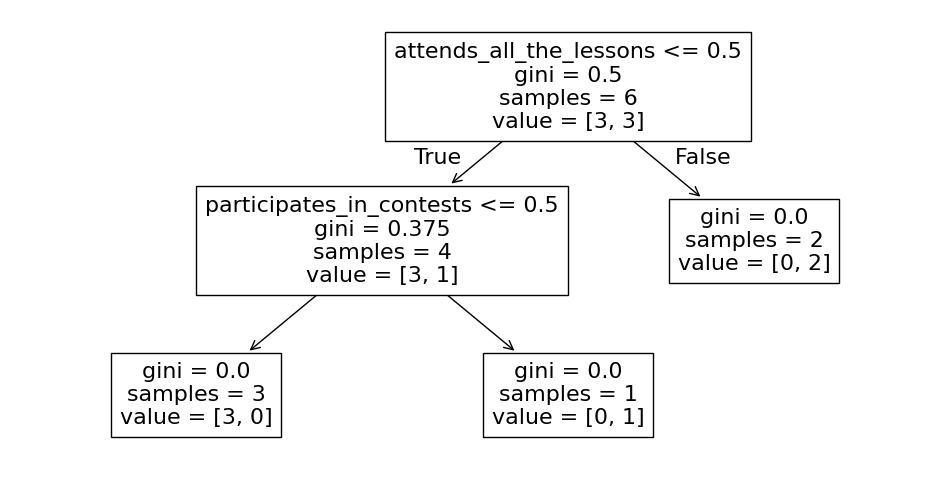

In [13]:
model = DecisionTreeClassifier()
model.fit(
    X=students_pd[feature_names],
    y=students_pd[target_name]
)

plt.figure(figsize=[12, 6])
tree.plot_tree(model, feature_names=list(feature_names));

### Расчет важностей фичей на примере дерева, решающего задачу классификации

Необходимо умножить прирост информации в сплите на долю элементов в листе, над которым производился сплит, от всей выбрки.

Для фичи *attends_all_the_lessons* важность равна:

In [14]:
0.25 * 6 / 6

0.25

Для фичи *participates_in_contests* важность равна:

In [15]:
0.375 * 4 / 6

0.25

Итоговые важности нормируются так, чтобы давать в сумме единицу.

In [16]:
pd.DataFrame(zip(feature_names, model.feature_importances_), columns=['feature', 'importance'])

,feature,importance
0,attends_all_the_lessons,0.5
1,completes_all_the_homeworks,0.0
2,participates_in_contests,0.5


### Обучение дерева решений для решения задачи регрессии

In [17]:
students_data_new = [
    {
        'student': 'Вася',
        'attends_all_the_lessons': 1,
        'completed_homeworks_count': 3,
        'participates_in_contests': 0,
        'final_score_in_exam': 79
    },
    {
        'student': 'Петя',
        'attends_all_the_lessons': 0,
        'completed_homeworks_count': 2,
        'participates_in_contests': 0,
        'final_score_in_exam': 63
    },
    {
        'student': 'Кристина',
        'attends_all_the_lessons': 0,
        'completed_homeworks_count': 4,
        'participates_in_contests': 1,
        'final_score_in_exam': 91
    },
    {
        'student': 'Полина',
        'attends_all_the_lessons': 0,
        'completed_homeworks_count': 2,
        'participates_in_contests': 0,
        'final_score_in_exam': 68
    },
    {
        'student': 'Егор',
        'attends_all_the_lessons': 1,
        'completed_homeworks_count': 4,
        'participates_in_contests': 0,
        'final_score_in_exam': 87
    },
    {
        'student': 'Света',
        'attends_all_the_lessons': 0,
        'completed_homeworks_count': 2,
        'participates_in_contests': 0,
        'final_score_in_exam': 52
    }
]
students_pd_new = pd.DataFrame(students_data_new)
students_pd_new

,student,attends_all_the_lessons,completed_homeworks_count,participates_in_contests,final_score_in_exam
0,Вася,1,3,0,79
1,Петя,0,2,0,63
2,Кристина,0,4,1,91
3,Полина,0,2,0,68
4,Егор,1,4,0,87
5,Света,0,2,0,52


In [18]:
def calc_squared_error(values):
    mean_value = values.mean()
    res = sum([(v - mean_value) ** 2 for v in values]) / len(values)
    return res

Рассчитаем исходный разброс

In [19]:
target_name_new = 'final_score_in_exam'

In [20]:
init_mse = calc_squared_error(students_pd_new[target_name_new])
init_mse

186.88888888888889

Строим первый сплит

In [21]:
feature_names = ['attends_all_the_lessons', 'completed_homeworks_count', 'participates_in_contests']

In [22]:
calc_options(students_pd_new, target_name_new, init_mse, calc_squared_error)

attends_all_the_lessons
    Split value = 0.5
        For students with feature less than 0.5 target equals 63 91 68 52 criterion equals 202.25
        For students with feature more than 0.5 target equals 79 87 criterion equals 16.0
        Information gain = 46.722222222222236

completed_homeworks_count
    Split value = 2.5
        For students with feature less than 2.5 target equals 63 68 52 criterion equals 44.666666666666664
        For students with feature more than 2.5 target equals 79 91 87 criterion equals 24.88888888888889
        Information gain = 152.1111111111111
    Split value = 3.5
        For students with feature less than 3.5 target equals 79 63 68 52 criterion equals 94.25
        For students with feature more than 3.5 target equals 91 87 criterion equals 4.0
        Information gain = 122.72222222222223

participates_in_contests
    Split value = 0.5
        For students with feature less than 0.5 target equals 79 63 68 87 52 criterion equals 149.3599999999999

Строим второй сплит

In [23]:
students_pd_new_after_1st_split_right = students_pd_new.query('completed_homeworks_count > 2.5').copy()
init_mse_after_1st_split_right = calc_squared_error(students_pd_new_after_1st_split_right[target_name_new])
init_mse_after_1st_split_right

24.88888888888889

In [24]:
calc_options(
    students_pd_new_after_1st_split_right, 
    target_name_new, 
    init_mse_after_1st_split_right, 
    calc_squared_error)

attends_all_the_lessons
    Split value = 0.5
        For students with feature less than 0.5 target equals 91 criterion equals 0.0
        For students with feature more than 0.5 target equals 79 87 criterion equals 16.0
        Information gain = 14.222222222222223

completed_homeworks_count
    Split value = 3.5
        For students with feature less than 3.5 target equals 79 criterion equals 0.0
        For students with feature more than 3.5 target equals 91 87 criterion equals 4.0
        Information gain = 22.22222222222222

participates_in_contests
    Split value = 0.5
        For students with feature less than 0.5 target equals 79 87 criterion equals 16.0
        For students with feature more than 0.5 target equals 91 criterion equals 0.0
        Information gain = 14.222222222222223

BEST feature_split: completed_homeworks_count_3.5 with information gain = 22.22222222222222


Строим третий сплит

In [25]:
students_pd_new_after_2st_split_right = students_pd_new_after_1st_split_right.query('completed_homeworks_count > 3.5')\
    .copy()
init_mse_after_2st_split_right = calc_squared_error(students_pd_new_after_2st_split_right[target_name_new])
init_mse_after_2st_split_right

4.0

In [26]:
calc_options(
    students_pd_new_after_2st_split_right.copy(), 
    target_name_new, 
    init_mse_after_2st_split_right, 
    calc_squared_error)

attends_all_the_lessons
    Split value = 0.5
        For students with feature less than 0.5 target equals 91 criterion equals 0.0
        For students with feature more than 0.5 target equals 87 criterion equals 0.0
        Information gain = 4.0

completed_homeworks_count

participates_in_contests
    Split value = 0.5
        For students with feature less than 0.5 target equals 87 criterion equals 0.0
        For students with feature more than 0.5 target equals 91 criterion equals 0.0
        Information gain = 4.0

BEST feature_split: attends_all_the_lessons_0.5 with information gain = 4.0


Проверим себя, построив дерево с помощью библиотечной реализации алгоритма

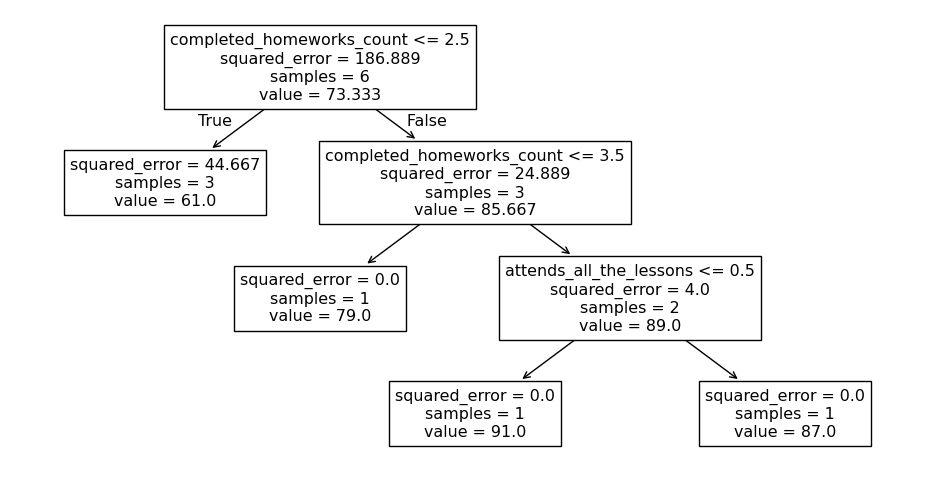

In [27]:
model_new = DecisionTreeRegressor()
model_new.fit(
    X=students_pd_new[feature_names],
    y=students_pd_new[target_name_new]
)

plt.figure(figsize=[12, 6])
tree.plot_tree(model_new, feature_names=list(feature_names));

### Расчет важностей фичей на примере дерева, решающего задачу регрессии

Для фичи *attends_all_lessons*

In [28]:
4.0 * 2 / 6

1.3333333333333333

Для фичи *completed_homeworks_count*

In [29]:
152.1111111111111 * 6 / 6 + 22.22222222222222 * 3 / 6

163.2222222222222

Далее нормируем, чтобы получать в сумме 100

In [30]:
coeff = 100 / (163.2222222222222 + 1.3333333333333333)

In [31]:
163.2222222222222 * coeff

99.18973666441593

In [32]:
1.3333333333333333 * coeff

0.8102633355840649

In [33]:
pd.DataFrame(zip(feature_names, model_new.feature_importances_), columns=['feature', 'importance'])

,feature,importance
0,attends_all_the_lessons,0.008103
1,completed_homeworks_count,0.991897
2,participates_in_contests,0.000000


### Переобучение и недообучение решающего дерева

Решаем задачу предсказания уровня трат покупателя по его входным данным:
- id покупателя
- пол покупателя
- возраст покупателя
- годовой доход покупателя

[Данные можно найти тут](https://www.kaggle.com/datasets/shwetabh123/mall-customers?resource=download)

In [34]:
# загружаем данные
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [35]:
# посмотрим тип данных и нет ли пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [36]:
# отделяем признаки
features = df[['Genre', 'Age', 'Annual Income (k$)']].copy()
features['Genre'] = (features['Genre'] == 'Male') * 1
features.head()

,Genre,Age,Annual Income (k$)
0,1,19,15
1,1,21,15
2,0,20,16
3,0,23,16
4,0,31,17


In [37]:
# отделяем целевую переменную
target = df['Spending Score (1-100)']

In [38]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=42)

Обучим очень сложное дерево

In [39]:
model = DecisionTreeRegressor(min_samples_leaf=1, random_state=1)

model.fit(features_train, target_train)
pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print(f'Качество на обучающей выборке: {mean_absolute_error(pred_train, target_train)}')
print(f'Качество на валидационной выборке: {mean_absolute_error(pred_test, target_test)}')

Качество на обучающей выборке: 0.6266666666666667
Качество на валидационной выборке: 19.0


In [40]:
model.get_depth()

17

Понаблюдаем как меняются ошибки в зависимости от сложности алгоритма

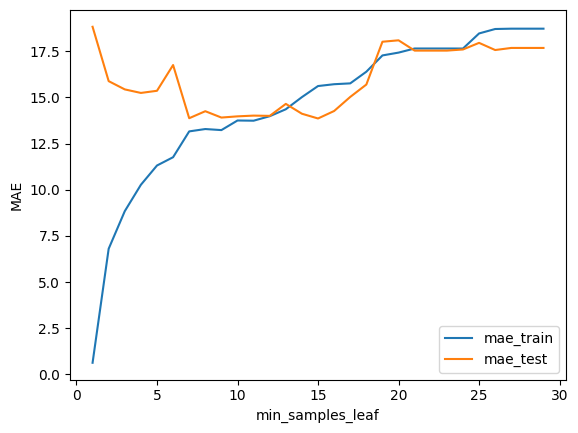

In [41]:
res = []
for param in range(1, 30, 1):
    model = DecisionTreeRegressor(min_samples_leaf=param, random_state=42)

    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    res.append([param, mean_absolute_error(pred_train, target_train), mean_absolute_error(pred_test, target_test)])
    
res_pd = pd.DataFrame(res, columns=['min_samples_leaf', 'mae_train', 'mae_test'])

res_pd.set_index('min_samples_leaf')['mae_train'].plot(label='mae_train')
res_pd.set_index('min_samples_leaf')['mae_test'].plot(label='mae_test')
plt.legend()
plt.ylabel('MAE');

In [42]:
res_pd[res_pd['mae_test'] == res_pd['mae_test'].min()]

,min_samples_leaf,mae_train,mae_test
14,15,15.61128,13.854993


### Случайный лес

In [45]:
from sklearn.ensemble import RandomForestRegressor

Решаем задачу оценки качества вина по 10-бальной шкале в зависимости от результатов замеров некоторых показателей (остаточный сахар, кислотность, крепость и др)  
[Данные можно найти тут](https://archive.ics.uci.edu/dataset/186/wine+quality)

In [46]:
df = pd.read_csv('winequality-red.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [48]:
features = df.drop(['quality'], axis=1)
target = df['quality']

In [49]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=42)

Выберем лучшее дерево

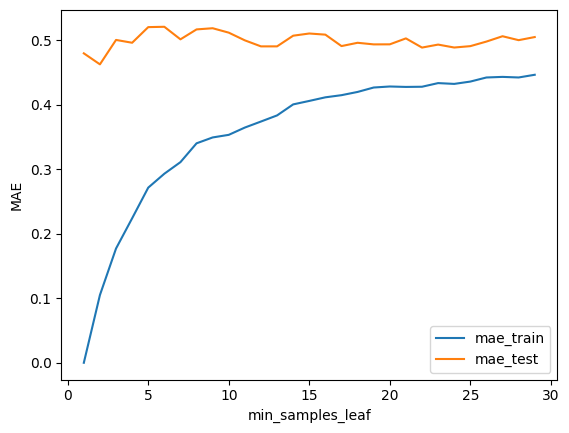

In [50]:
res = []
for param in range(1, 30, 1):
    model = DecisionTreeRegressor(min_samples_leaf=param, random_state=7)

    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    res.append([param, mean_absolute_error(pred_train, target_train), mean_absolute_error(pred_test, target_test)])
    
res_pd = pd.DataFrame(res, columns=['min_samples_leaf', 'mae_train', 'mae_test'])

res_pd.set_index('min_samples_leaf')['mae_train'].plot(label='mae_train')
res_pd.set_index('min_samples_leaf')['mae_test'].plot(label='mae_test')
plt.legend()
plt.ylabel('MAE');

In [51]:
res_pd[res_pd['mae_test'] == res_pd['mae_test'].min()]

,min_samples_leaf,mae_train,mae_test
1,2,0.105088,0.462917


Увеличим число деревьев

In [52]:
model = RandomForestRegressor(n_estimators=5, min_samples_leaf=2, random_state=7)

model.fit(features_train, target_train)
pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print(f'Ошибка на обучающей выборке: {mean_absolute_error(pred_train, target_train)}')
print(f'Ошибка на валидационной выборке: {mean_absolute_error(pred_test, target_test)}')

Ошибка на обучающей выборке: 0.23516025259144524
Ошибка на валидационной выборке: 0.4569750000000001


Попробуем обучить много деревьев

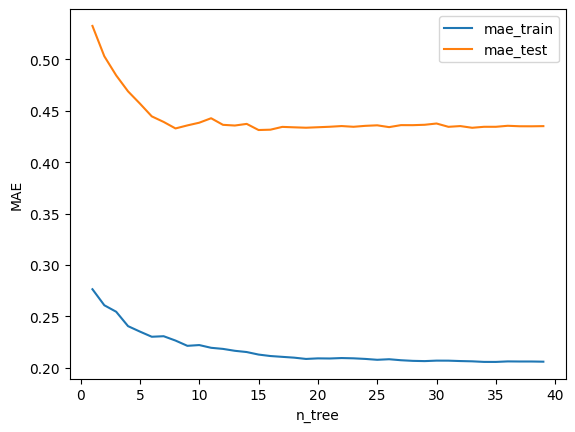

In [53]:
res = []
for n_tree in range(1, 40):
    model = RandomForestRegressor(n_estimators=n_tree, min_samples_leaf=2, random_state=7)

    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    res.append([n_tree, mean_absolute_error(pred_train, target_train), mean_absolute_error(pred_test, target_test)])

res_pd = pd.DataFrame(res, columns=['n_tree', 'mae_train', 'mae_test'])

res_pd.set_index('n_tree')['mae_train'].plot(label='mae_train')
res_pd.set_index('n_tree')['mae_test'].plot(label='mae_test')
plt.legend()
plt.ylabel('MAE');